In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, normaltest, kstest
import os


In [ ]:
import pandas as pd
df_avaliacoes_pntp_2024_2 = pd.read_csv('../Data/raw/Atricon/avaliacoes_pntp_2024/avaliacoes_pntp_2024.csv')
df_avaliacoes_pntp_2024_2

,ano_exercicio,questionario_id,entidade_id,entidade,ibge,municipio,capital,uf,poder,esfera,...,nivel_avaliacao,indice_validacao,essenciais_validacao,nivel_validacao,indice_revisao,essenciais_revisao,nivel_revisao,indice_final,essenciais_final,nivel_final
0,2024,9768,12,Prefeitura Municipal de Abel Figueiredo,1500131,Abel Figueiredo,False,PA,E,M,...,Diamante,96.50,100.00,Diamante,NaN,NaN,NaN,96.50,100.00,Diamante
1,2024,12808,2591,Prefeitura Municipal de João Lisboa,2105500,João Lisboa,False,MA,E,M,...,Diamante,87.67,100.00,Ouro,NaN,NaN,NaN,87.67,100.00,Ouro
2,2024,11084,5641,Câmara Municipal de Águas Frias,4200556,Águas Frias,False,SC,L,M,...,Ouro,68.58,76.19,Intermediário,NaN,NaN,NaN,68.58,76.19,Intermediário
3,2024,14850,5909,Câmara Municipal de Araquari,4201307,Araquari,False,SC,L,M,...,Ouro,66.92,76.19,Intermediário,NaN,NaN,NaN,66.92,76.19,Intermediário
4,2024,13318,10352,Câmara Municipal de São José do Piauí,2210201,São José do Piauí,False,PI,L,M,...,Intermediário,39.24,90.48,Básico,NaN,NaN,NaN,39.24,90.48,Básico
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7365,2024,15386,113,Prefeitura Municipal de Alfredo Marcondes,3500808,Alfredo Marcondes,False,SP,E,M,...,Intermediário,NaN,NaN,NaN,NaN,NaN,NaN,63.76,100.00,Intermediário
7366,2024,11782,4357,Prefeitura Municipal de Santa Carmem,5107248,Santa Carmem,False,MT,E,M,...,Intermediário,NaN,NaN,NaN,NaN,NaN,NaN,66.79,100.00,Intermediário
7367,2024,14260,1321,Prefeitura Municipal de Comendador Levy Gasparian,3300951,Comendador Levy Gasparian,False,RJ,E,M,...,Intermediário,NaN,NaN,NaN,NaN,NaN,NaN,55.50,81.82,Intermediário
7368,2024,16738,10677,Câmara Municipal de Tabapuã,3552601,Tabapuã,False,SP,L,M,...,Básico,NaN,NaN,NaN,NaN,NaN,NaN,32.73,28.57,Básico


In [44]:
# 2. FILTRAR APENAS PREFEITURAS DE RONDÔNIA
df_rondonia = df_1[
    (df_1['uf'] == 'RO') &                    # Rondônia
    (df_1['poder'] == 'E') &                  # Executivo
    (df_1['esfera'] == 'M') &                 # Municipal
    (df_1['entidade'].str.contains('Prefeitura', case=False, na=False))
].copy()

print(f"\nMunicípios de Rondônia encontrados: {len(df_rondonia)}")



Municípios de Rondônia encontrados: 52


In [45]:
# 3. SELECIONAR COLUNAS PRINCIPAIS
colunas = [
    'municipio',
    'ibge',
    'indice_final',
    'essenciais_final',
    'nivel_final',
    'status'
]
df_ro = df_rondonia[colunas].sort_values('municipio').reset_index(drop=True)


In [1]:
# TESTE DE NORMALIDADE - SHAPIRO-WILK

# Objetivo: Verificar se os dados seguem distribuição normal para determinar se devemos usar testes paramétricos ou não-paramétricos

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# 1. CARREGAR DADOS

def carregar_dados_rondonia():
    """Carrega dados filtrados de Rondônia"""
    import os
    
    # Construct absolute path relative to notebook
    base_dir = os.getcwd()
    file_path = os.path.join(base_dir, 'coleta_de_dados', 'Atricon',
                             'avaliacoes_pntp_2024', 'avaliacoes_pntp_2024.csv')
    
    # Check if file exists before trying to read
    if not os.path.exists(file_path):
        # Try alternative: maybe we're already in workspace
        alt_path = os.path.join('coleta_de_dados', 'Atricon',
                                'avaliacoes_pntp_2024', 'avaliacoes_pntp_2024.csv')
        if os.path.exists(alt_path):
            file_path = alt_path
        else:
            raise FileNotFoundError(
                f"CSV file not found. Tried:\n"
                f"1. {file_path}\n"
                f"2. {alt_path}\n"
                f"Current working directory: {os.getcwd()}"
            )
    
    df = pd.read_csv(file_path, sep=';', encoding='utf-8')
    
    df_ro = df[
        (df['uf'] == 'RO') &
        (df['poder'] == 'E') &
        (df['esfera'] == 'M') &
        (df['entidade'].str.contains('Prefeitura', case=False, na=False))
    ].copy()
    
    return df_ro


# 2. TESTE DE SHAPIRO-WILK
def teste_shapiro_wilk(dados, nome_variavel, alfa=0.05):
    """
    Realiza teste de Shapiro-Wilk para normalidade.
    
    H0: Os dados seguem distribuição normal
    H1: Os dados NÃO seguem distribuição normal
    
    Parâmetros:
    -----------
    dados : array-like
        Dados a serem testados
    nome_variavel : str
        Nome da variável (para exibição)
    alfa : float
        Nível de significância (padrão: 0.05)
    
    Retorna:
    --------
    dict : Resultados do teste
    """
    
    # Remover valores NaN
    dados_limpos = dados.dropna()
    
    # Teste de Shapiro-Wilk
    statistic, p_value = shapiro(dados_limpos)
    
    # Interpretação
    if p_value > alfa:
        interpretacao = "ACEITA H0: Dados seguem distribuição NORMAL"
        conclusao = "Pode usar testes PARAMÉTRICOS (t-test, ANOVA)"
        cor = "🟢"
    else:
        interpretacao = "REJEITA H0: Dados NÃO seguem distribuição normal"
        conclusao = "Deve usar testes NÃO-PARAMÉTRICOS (Mann-Whitney, Kruskal-Wallis)"
        cor = "🔴"
    
    return {
        'variavel': nome_variavel,
        'n': len(dados_limpos),
        'statistic': statistic,
        'p_value': p_value,
        'alfa': alfa,
        'interpretacao': interpretacao,
        'conclusao': conclusao,
        'cor': cor,
        'normal': p_value > alfa
    }


# 3. TESTES ADICIONAIS DE NORMALIDADE


def testes_normalidade_completos(dados, nome_variavel):
    """
    Realiza múltiplos testes de normalidade para maior robustez.
    """
    
    dados_limpos = dados.dropna()
    
    print(f"\n{'='*70}")
    print(f"TESTES DE NORMALIDADE: {nome_variavel}")
    print(f"{'='*70}")
    print(f"Tamanho da amostra: n = {len(dados_limpos)}")
    
    # 1. Shapiro-Wilk (mais poderoso para n < 50)
    shapiro_stat, shapiro_p = shapiro(dados_limpos)
    print(f"\n1. SHAPIRO-WILK")
    print(f"   Estatística W: {shapiro_stat:.6f}")
    print(f"   P-valor: {shapiro_p:.6f}")
    print(f"   Conclusão: {'Normal ✓' if shapiro_p > 0.05 else 'Não-normal ✗'}")
    
    # 2. D'Agostino-Pearson (k² test)
    dagostino_stat, dagostino_p = normaltest(dados_limpos)
    print(f"\n2. D'AGOSTINO-PEARSON")
    print(f"   Estatística k²: {dagostino_stat:.6f}")
    print(f"   P-valor: {dagostino_p:.6f}")
    print(f"   Conclusão: {'Normal ✓' if dagostino_p > 0.05 else 'Não-normal ✗'}")
    
    # 3. Kolmogorov-Smirnov (comparação com normal)
    media = dados_limpos.mean()
    desvio = dados_limpos.std()
    ks_stat, ks_p = kstest(dados_limpos, lambda x: stats.norm.cdf(x, media, desvio))
    print(f"\n3. KOLMOGOROV-SMIRNOV")
    print(f"   Estatística D: {ks_stat:.6f}")
    print(f"   P-valor: {ks_p:.6f}")
    print(f"   Conclusão: {'Normal ✓' if ks_p > 0.05 else 'Não-normal ✗'}")
    
    # 4. Estatísticas descritivas de assimetria e curtose
    assimetria = stats.skew(dados_limpos)
    curtose = stats.kurtosis(dados_limpos)
    print(f"\n4. ASSIMETRIA E CURTOSE")
    print(f"   Assimetria (Skewness): {assimetria:.4f}")
    print(f"   Interpretação: ", end="")
    if abs(assimetria) < 0.5:
        print("Aproximadamente simétrica ✓")
    elif abs(assimetria) < 1:
        print("Moderadamente assimétrica")
    else:
        print("Altamente assimétrica ✗")
    
    print(f"   Curtose (Kurtosis): {curtose:.4f}")
    print(f"   Interpretação: ", end="")
    if abs(curtose) < 0.5:
        print("Aproximadamente mesocúrtica (normal) ✓")
    elif curtose > 0:
        print("Leptocúrtica (pico mais alto que normal)")
    else:
        print("Platicúrtica (mais achatada que normal)")
    
    # Conclusão geral
    print(f"\n{'='*70}")
    print("CONCLUSÃO GERAL:")
    print(f"{'='*70}")
    
    testes_normais = sum([shapiro_p > 0.05, dagostino_p > 0.05, ks_p > 0.05])
    
    if testes_normais >= 2:
        print("✅ DADOS APROXIMADAMENTE NORMAIS")
        print("   → Pode usar testes PARAMÉTRICOS com cautela")
        print("   → Recomendado: verificar também pelo Q-Q plot")
    else:
        print("❌ DADOS NÃO SEGUEM DISTRIBUIÇÃO NORMAL")
        print("   → USAR TESTES NÃO-PARAMÉTRICOS")
        print("   → Kruskal-Wallis (no lugar de ANOVA)")
        print("   → Mann-Whitney U (no lugar de t-test)")
        print("   → Spearman (no lugar de Pearson)")
    
    return {
        'shapiro_p': shapiro_p,
        'dagostino_p': dagostino_p,
        'ks_p': ks_p,
        'assimetria': assimetria,
        'curtose': curtose,
        'normal': testes_normais >= 2
    }


# 4. VISUALIZAÇÕES

def visualizar_normalidade(dados, nome_variavel):
    """
    Cria visualizações para avaliar normalidade:
    1. Histograma com curva normal sobreposta
    2. Q-Q Plot
    3. Boxplot
    4. Densidade (KDE)
    """
    
    dados_limpos = dados.dropna()
    
    fig = plt.figure(figsize=(16, 10))
    
    # 1. HISTOGRAMA COM CURVA NORMAL
    ax1 = plt.subplot(2, 3, 1)
    n, bins, patches = plt.hist(dados_limpos, bins=15, density=True, 
                                 alpha=0.7, color='skyblue', edgecolor='black')
    
    # Curva normal teórica
    mu = dados_limpos.mean()
    sigma = dados_limpos.std()
    x = np.linspace(dados_limpos.min(), dados_limpos.max(), 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, 
             label=f'Normal(μ={mu:.2f}, σ={sigma:.2f})')
    
    plt.axvline(mu, color='red', linestyle='--', linewidth=2, label='Média')
    plt.axvline(mu - sigma, color='orange', linestyle='--', linewidth=1, alpha=0.7)
    plt.axvline(mu + sigma, color='orange', linestyle='--', linewidth=1, alpha=0.7)
    
    plt.xlabel(nome_variavel)
    plt.ylabel('Densidade')
    plt.title(f'Histograma + Distribuição Normal Teórica\n{nome_variavel}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Q-Q PLOT
    ax2 = plt.subplot(2, 3, 2)
    stats.probplot(dados_limpos, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot (Quantil-Quantil)\n{nome_variavel}')
    plt.grid(True, alpha=0.3)
    
    # 3. BOXPLOT
    ax3 = plt.subplot(2, 3, 3)
    bp = plt.boxplot(dados_limpos, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    plt.ylabel(nome_variavel)
    plt.title(f'Boxplot\n{nome_variavel}')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Adicionar estatísticas ao boxplot
    q1 = np.percentile(dados_limpos, 25)
    mediana = np.percentile(dados_limpos, 50)
    q3 = np.percentile(dados_limpos, 75)
    iqr = q3 - q1
    
    plt.text(1.2, q1, f'Q1: {q1:.2f}', fontsize=9)
    plt.text(1.2, mediana, f'Med: {mediana:.2f}', fontsize=9, fontweight='bold')
    plt.text(1.2, q3, f'Q3: {q3:.2f}', fontsize=9)
    
    # 4. DENSIDADE (KDE)
    ax4 = plt.subplot(2, 3, 4)
    dados_limpos.plot(kind='density', color='blue', linewidth=2)
    plt.axvline(mu, color='red', linestyle='--', linewidth=2, label='Média')
    plt.axvline(mediana, color='green', linestyle='--', linewidth=2, label='Mediana')
    plt.xlabel(nome_variavel)
    plt.ylabel('Densidade')
    plt.title(f'Densidade (KDE)\n{nome_variavel}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. DESVIOS DA NORMAL (Residuals)
    ax5 = plt.subplot(2, 3, 5)
    residuos = (dados_limpos - mu) / sigma
    plt.scatter(range(len(residuos)), residuos, alpha=0.6, s=50)
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    plt.axhline(2, color='orange', linestyle='--', linewidth=1, alpha=0.7)
    plt.axhline(-2, color='orange', linestyle='--', linewidth=1, alpha=0.7)
    plt.xlabel('Observação')
    plt.ylabel('Resíduos Padronizados')
    plt.title('Resíduos Padronizados\n(valores entre -2 e 2 são esperados)')
    plt.grid(True, alpha=0.3)
    
    # 6. ESTATÍSTICAS RESUMIDAS
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    estatisticas = f"""
    ESTATÍSTICAS DESCRITIVAS
    {'='*35}
    
    N:                {len(dados_limpos)}
    Média:            {mu:.2f}
    Mediana:          {mediana:.2f}
    Desvio Padrão:    {sigma:.2f}
    Mínimo:           {dados_limpos.min():.2f}
    Máximo:           {dados_limpos.max():.2f}
    
    Q1 (25%):         {q1:.2f}
    Q3 (75%):         {q3:.2f}
    IQR:              {iqr:.2f}
    
    Assimetria:       {stats.skew(dados_limpos):.4f}
    Curtose:          {stats.kurtosis(dados_limpos):.4f}
    
    {'='*35}
    INTERPRETAÇÃO:
    
    • Se Q-Q plot segue linha reta:
      → Distribuição próxima à normal
    
    • Se histograma se aproxima da 
      curva vermelha:
      → Distribuição próxima à normal
    
    • Se assimetria ≈ 0 e curtose ≈ 0:
      → Distribuição próxima à normal
    """
    
    ax6.text(0.1, 0.95, estatisticas, transform=ax6.transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.suptitle(f'ANÁLISE DE NORMALIDADE - {nome_variavel}', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.savefig(f'normalidade_{nome_variavel.lower().replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    print(f"\n✓ Gráfico salvo: normalidade_{nome_variavel.lower().replace(' ', '_')}.png")
    
    return fig

# 5. ANÁLISE COMPLETA


def analise_normalidade_completa(df_ro):
    """Executa análise completa de normalidade para todas as variáveis relevantes"""
    
    print("\n" + "="*70)
    print("ANÁLISE DE NORMALIDADE - DADOS ABERTOS RONDÔNIA")
    print("Teste de Shapiro-Wilk + Visualizações")
    print("="*70)
    
    # Variáveis a testar
    variaveis = {
        'indice_final': 'Índice Final de Transparência',
        'essenciais_final': 'Quesitos Essenciais (%)'
    }
    
    resultados = {}
    
    for coluna, nome in variaveis.items():
        if coluna in df_ro.columns:
            print(f"\n{'='*70}")
            print(f"ANALISANDO: {nome}")
            print(f"{'='*70}")
            
            # Testes de normalidade
            resultado = testes_normalidade_completos(df_ro[coluna], nome)
            resultados[nome] = resultado
            
            # Visualizações
            visualizar_normalidade(df_ro[coluna], nome)
        else:
            print(f"\n⚠ Coluna '{coluna}' não encontrada no dataset")
    
    # Resumo final
    print("\n" + "="*70)
    print("RESUMO FINAL - TODAS AS VARIÁVEIS")
    print("="*70)
    
    print(f"\n{'Variável':40s} | Shapiro-Wilk | Normal?")
    print("-" * 70)
    
    for nome, resultado in resultados.items():
        normal_str = "✅ SIM" if resultado['normal'] else "❌ NÃO"
        print(f"{nome:40s} | p={resultado['shapiro_p']:.4f}  | {normal_str}")
    
    # Recomendação final
    print("\n" + "="*70)
    print("🎯 RECOMENDAÇÃO PARA SUA DISSERTAÇÃO")
    print("="*70)
    
    todas_normais = all(r['normal'] for r in resultados.values())
    
    if todas_normais:
        print("""
✅ DADOS SEGUEM DISTRIBUIÇÃO APROXIMADAMENTE NORMAL

TESTES RECOMENDADOS:
• Comparação de 2 grupos: Teste t de Student
• Comparação de 3+ grupos: ANOVA
• Correlação: Coeficiente de Pearson

OBSERVAÇÃO: Mesmo com normalidade, considere usar testes não-paramétricos
como análise de sensibilidade, especialmente com n=13 na amostra final.
        """)
    else:
        print("""
❌ DADOS NÃO SEGUEM DISTRIBUIÇÃO NORMAL

TESTES OBRIGATÓRIOS (NÃO-PARAMÉTRICOS):
• Comparação de 2 grupos: Mann-Whitney U
• Comparação de 3+ grupos: Kruskal-Wallis
• Correlação: Coeficiente de Spearman

JUSTIFICATIVA PARA A DISSERTAÇÃO:
"Os testes de normalidade (Shapiro-Wilk, D'Agostino-Pearson) indicaram
que os dados não seguem distribuição normal (p < 0.05). Portanto, 
optou-se por testes não-paramétricos para todas as análises inferenciais,
que não pressupõem normalidade e são mais robustos para amostras pequenas."
        """)
    
    return resultados


# 6. FUNÇÃO PRINCIPAL


def main():
    """Executa análise completa de normalidade"""
    
    print("\n" + "="*70)
    print("🔬 TESTE DE NORMALIDADE (SHAPIRO-WILK)")
    print("Dados Abertos Orçamentários - Rondônia")
    print("="*70)
    
    # Carregar dados
    print("\nCarregando dados...")
    df_ro = carregar_dados_rondonia()
    print(f"✓ {len(df_ro)} municípios carregados")
    
    # Análise completa
    resultados = analise_normalidade_completa(df_ro)
    
    # Mostrar gráficos
    plt.show()
    
    print("\n" + "="*70)
    print("✅ ANÁLISE CONCLUÍDA")
    print("="*70)
    
    return df_ro, resultados


# Executar
if __name__ == "__main__":
    df_ro, resultados = main()


NameError: name 'plt' is not defined

In [21]:
# 4. ESTATÍSTICAS RÁPIDAS
print(f"\nÍndice médio: {df_ro['indice_final'].mean():.2f}")
print(f"Mediana: {df_ro['indice_final'].median():.2f}")



Índice médio: 75.62
Mediana: 75.94


In [20]:
# ESTRATEGIA 1 - AMOSTRAGEM PROPORCIONAL  (n=12)

# Preparar os dados por estrato (nível de transparência)
diamante = df_ro[df_ro['nivel_final'] == 'Diamante']['indice_final'].values
ouro = df_ro[df_ro['nivel_final'] == 'Ouro']['indice_final'].values
prata = df_ro[df_ro['nivel_final'] == 'Prata']['indice_final'].values
intermediario = df_ro[df_ro['nivel_final'] == 'Intermediário']['indice_final'].values
basico = df_ro[df_ro['nivel_final'] == 'Básico']['indice_final'].values

# Verificar tamanhos dos grupos
print("Tamanho dos grupos:")
print(f"Diamante: {len(diamante)}")
print(f"Ouro: {len(ouro)}")
print(f"Prata: {len(prata)}")
print(f"Intermediário: {len(intermediario)}")
print(f"Básico: {len(basico)}")

# Teste de diferença entre estratos (Kruskal-Wallis)
from scipy.stats import kruskal

# Remover grupos vazios antes do teste
grupos = [g for g in [diamante, ouro, prata, intermediario, basico] if len(g) > 0]

if len(grupos) >= 2:
    resultado = kruskal(*grupos)
    print(f"\nResultado do teste Kruskal-Wallis:")
    print(f"Estatística H: {resultado.statistic:.4f}")
    print(f"P-valor: {resultado.pvalue:.4f}")

    if resultado.pvalue < 0.05:
        print("Há diferenças estatisticamente significativas entre os estratos (p < 0.05)")
    else:
        print("Não há diferenças estatisticamente significativas entre os estratos (p >= 0.05)")
else:
    print("Dados insuficientes para o teste Kruskal-Wallis (precisa de pelo menos 2 grupos)")

# Correlação entre variáveis
from scipy.stats import spearmanr

Tamanho dos grupos:
Diamante: 5
Ouro: 9
Prata: 20
Intermediário: 16
Básico: 2

Resultado do teste Kruskal-Wallis:
Estatística H: 46.3171
P-valor: 0.0000
Há diferenças estatisticamente significativas entre os estratos (p < 0.05)


Silhouette Score: 0.568
(Quanto mais próximo de 1, melhor a qualidade dos clusters)

=== ESTATÍSTICAS POR CLUSTER ===

--- Cluster 0 (n=36) ---
Índice médio: 82.35
Essenciais médio: 100.00
Níveis: {'Prata': 20, 'Ouro': 9, 'Diamante': 5, 'Intermediário': 2}

--- Cluster 1 (n=2) ---
Índice médio: 54.09
Essenciais médio: 63.64
Níveis: {'Básico': 1, 'Intermediário': 1}

--- Cluster 2 (n=14) ---
Índice médio: 61.39
Essenciais médio: 97.19
Níveis: {'Intermediário': 13, 'Básico': 1}

=== TESTE KRUSKAL-WALLIS ===
H-statistic: 32.726
P-valor: 0.0000
✓ Há diferenças significativas entre os clusters (p < 0.05)


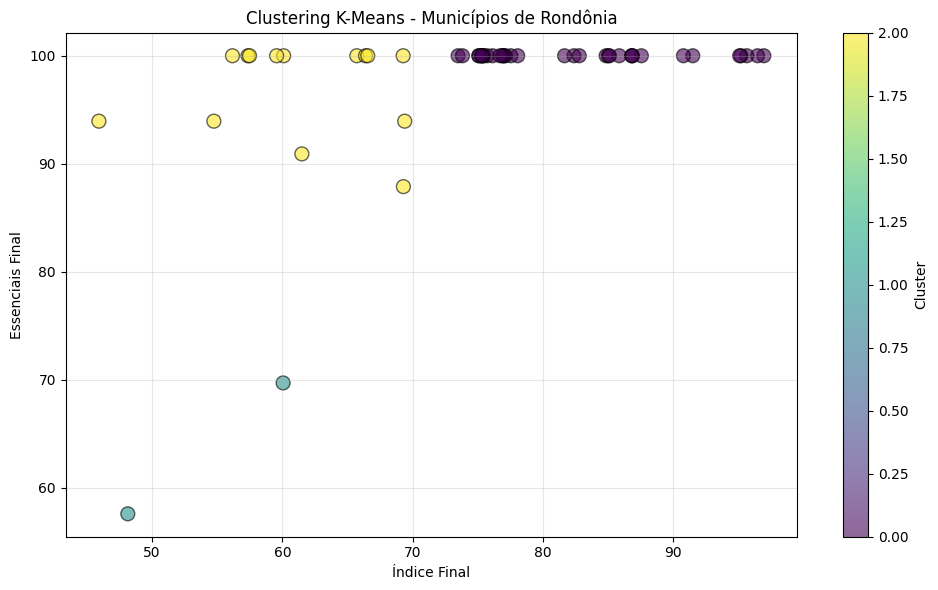


=== MUNICÍPIOS MAIS PRÓXIMOS DO CENTROIDE DE CADA CLUSTER ===

Cluster 0:
  - Presidente Médici: índice=82.40, essenciais=100.00
  - São Felipe D'Oeste: índice=82.81, essenciais=100.00
  - Teixeirópolis: índice=81.68, essenciais=100.00

Cluster 1:
  - Nova Mamoré: índice=48.13, essenciais=57.58
  - Vilhena: índice=60.06, essenciais=69.70

Cluster 2:
  - Corumbiara: índice=60.10, essenciais=100.00
  - São Miguel do Guaporé: índice=59.56, essenciais=100.00
  - Guajará-Mirim: índice=57.48, essenciais=100.00

✓ Porto Velho está no Cluster 0
  Índice: 95.23


In [18]:

#ESTRATÉGIA 2: AMOSTRAGEM POR CLUSTERS K-MEANS (n=9)
#Cluster por: Alto, medio e baixo desempenho

# - Selecionar municípios mais próximos do centroide de cada cluster
# - Garantir Porto Velho na amostra (independente do cluster, como caso especial)
# - Distribuição proporcional ao tamanho dos clusters

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.stats import kruskal

# Passo 1: Preparar as features para clustering
# Selecionar apenas colunas numéricas relevantes
features_df = df_ro[['indice_final', 'essenciais_final']].copy()

# Remover valores ausentes se houver
features_df = features_df.dropna()

# Guardar índices originais para mapear de volta
indices_validos = features_df.index

# Passo 2: Normalizar as features (importante para K-Means)
scaler = StandardScaler()
features = scaler.fit_transform(features_df)

# Passo 3: Aplicar K-Means clustering
n_clusters = 3  # Alto, médio e baixo desempenho
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(features)

# Passo 4: Validação do clustering
score = silhouette_score(features, kmeans.labels_)
print(f"Silhouette Score: {score:.3f}")
print(f"(Quanto mais próximo de 1, melhor a qualidade dos clusters)")

# Passo 5: Adicionar labels dos clusters ao dataframe
df_ro_cluster = df_ro.loc[indices_validos].copy()
df_ro_cluster['cluster'] = kmeans.labels_

# Passo 6: Análise descritiva dos clusters
print("\n=== ESTATÍSTICAS POR CLUSTER ===")
for i in range(n_clusters):
    cluster_data = df_ro_cluster[df_ro_cluster['cluster'] == i]
    print(f"\n--- Cluster {i} (n={len(cluster_data)}) ---")
    print(f"Índice médio: {cluster_data['indice_final'].mean():.2f}")
    print(f"Essenciais médio: {cluster_data['essenciais_final'].mean():.2f}")
    print(f"Níveis: {cluster_data['nivel_final'].value_counts().to_dict()}")

# Passo 7: Teste de Kruskal-Wallis para validar diferenças entre clusters
clusters_grupos = [
    df_ro_cluster[df_ro_cluster['cluster'] == i]['indice_final'].values
    for i in range(n_clusters)
]

h_stat, p_value = kruskal(*clusters_grupos)
print(f"\n=== TESTE KRUSKAL-WALLIS ===")
print(f"H-statistic: {h_stat:.3f}")
print(f"P-valor: {p_value:.4f}")

if p_value < 0.05:
    print("✓ Há diferenças significativas entre os clusters (p < 0.05)")
else:
    print("✗ Não há diferenças significativas entre os clusters (p >= 0.05)")

# Passo 8: Visualizar os clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_ro_cluster['indice_final'],
    df_ro_cluster['essenciais_final'],
    c=df_ro_cluster['cluster'],
    cmap='viridis',
    s=100,
    alpha=0.6,
    edgecolors='black'
)
plt.xlabel('Índice Final')
plt.ylabel('Essenciais Final')
plt.title('Clustering K-Means - Municípios de Rondônia')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Passo 9: Identificar municípios mais representativos de cada cluster
print("\n=== MUNICÍPIOS MAIS PRÓXIMOS DO CENTROIDE DE CADA CLUSTER ===")
centroides_originais = scaler.inverse_transform(kmeans.cluster_centers_)

for i in range(n_clusters):
    cluster_data = df_ro_cluster[df_ro_cluster['cluster'] == i].copy()
    centroide = centroides_originais[i]

    # Calcular distância euclidiana de cada município ao centroide
    cluster_data['distancia_centroide'] = np.sqrt(
        (cluster_data['indice_final'] - centroide[0])**2 +
        (cluster_data['essenciais_final'] - centroide[1])**2
    )

    # Selecionar os 3 mais próximos
    mais_proximos = cluster_data.nsmallest(3, 'distancia_centroide')

    print(f"\nCluster {i}:")
    for idx, row in mais_proximos.iterrows():
        print(f"  - {row['municipio']}: índice={row['indice_final']:.2f}, essenciais={row['essenciais_final']:.2f}")

# Passo 10: Verificar se Porto Velho está na amostra
porto_velho = df_ro_cluster[df_ro_cluster['municipio'].str.contains('Porto Velho', case=False, na=False)]
if len(porto_velho) > 0:
    print(f"\n✓ Porto Velho está no Cluster {porto_velho['cluster'].values[0]}")
    print(f"  Índice: {porto_velho['indice_final'].values[0]:.2f}")
else:
    print("\n⚠ Porto Velho não encontrado nos dados")